In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
pp = np.loadtxt("pp/pp_0.csv", delimiter=',')

In [3]:
img = np.zeros([1024, 1024], dtype=np.uint8)

In [4]:
for i, j in pp:
    img[284+int(j), int(i)] = 255

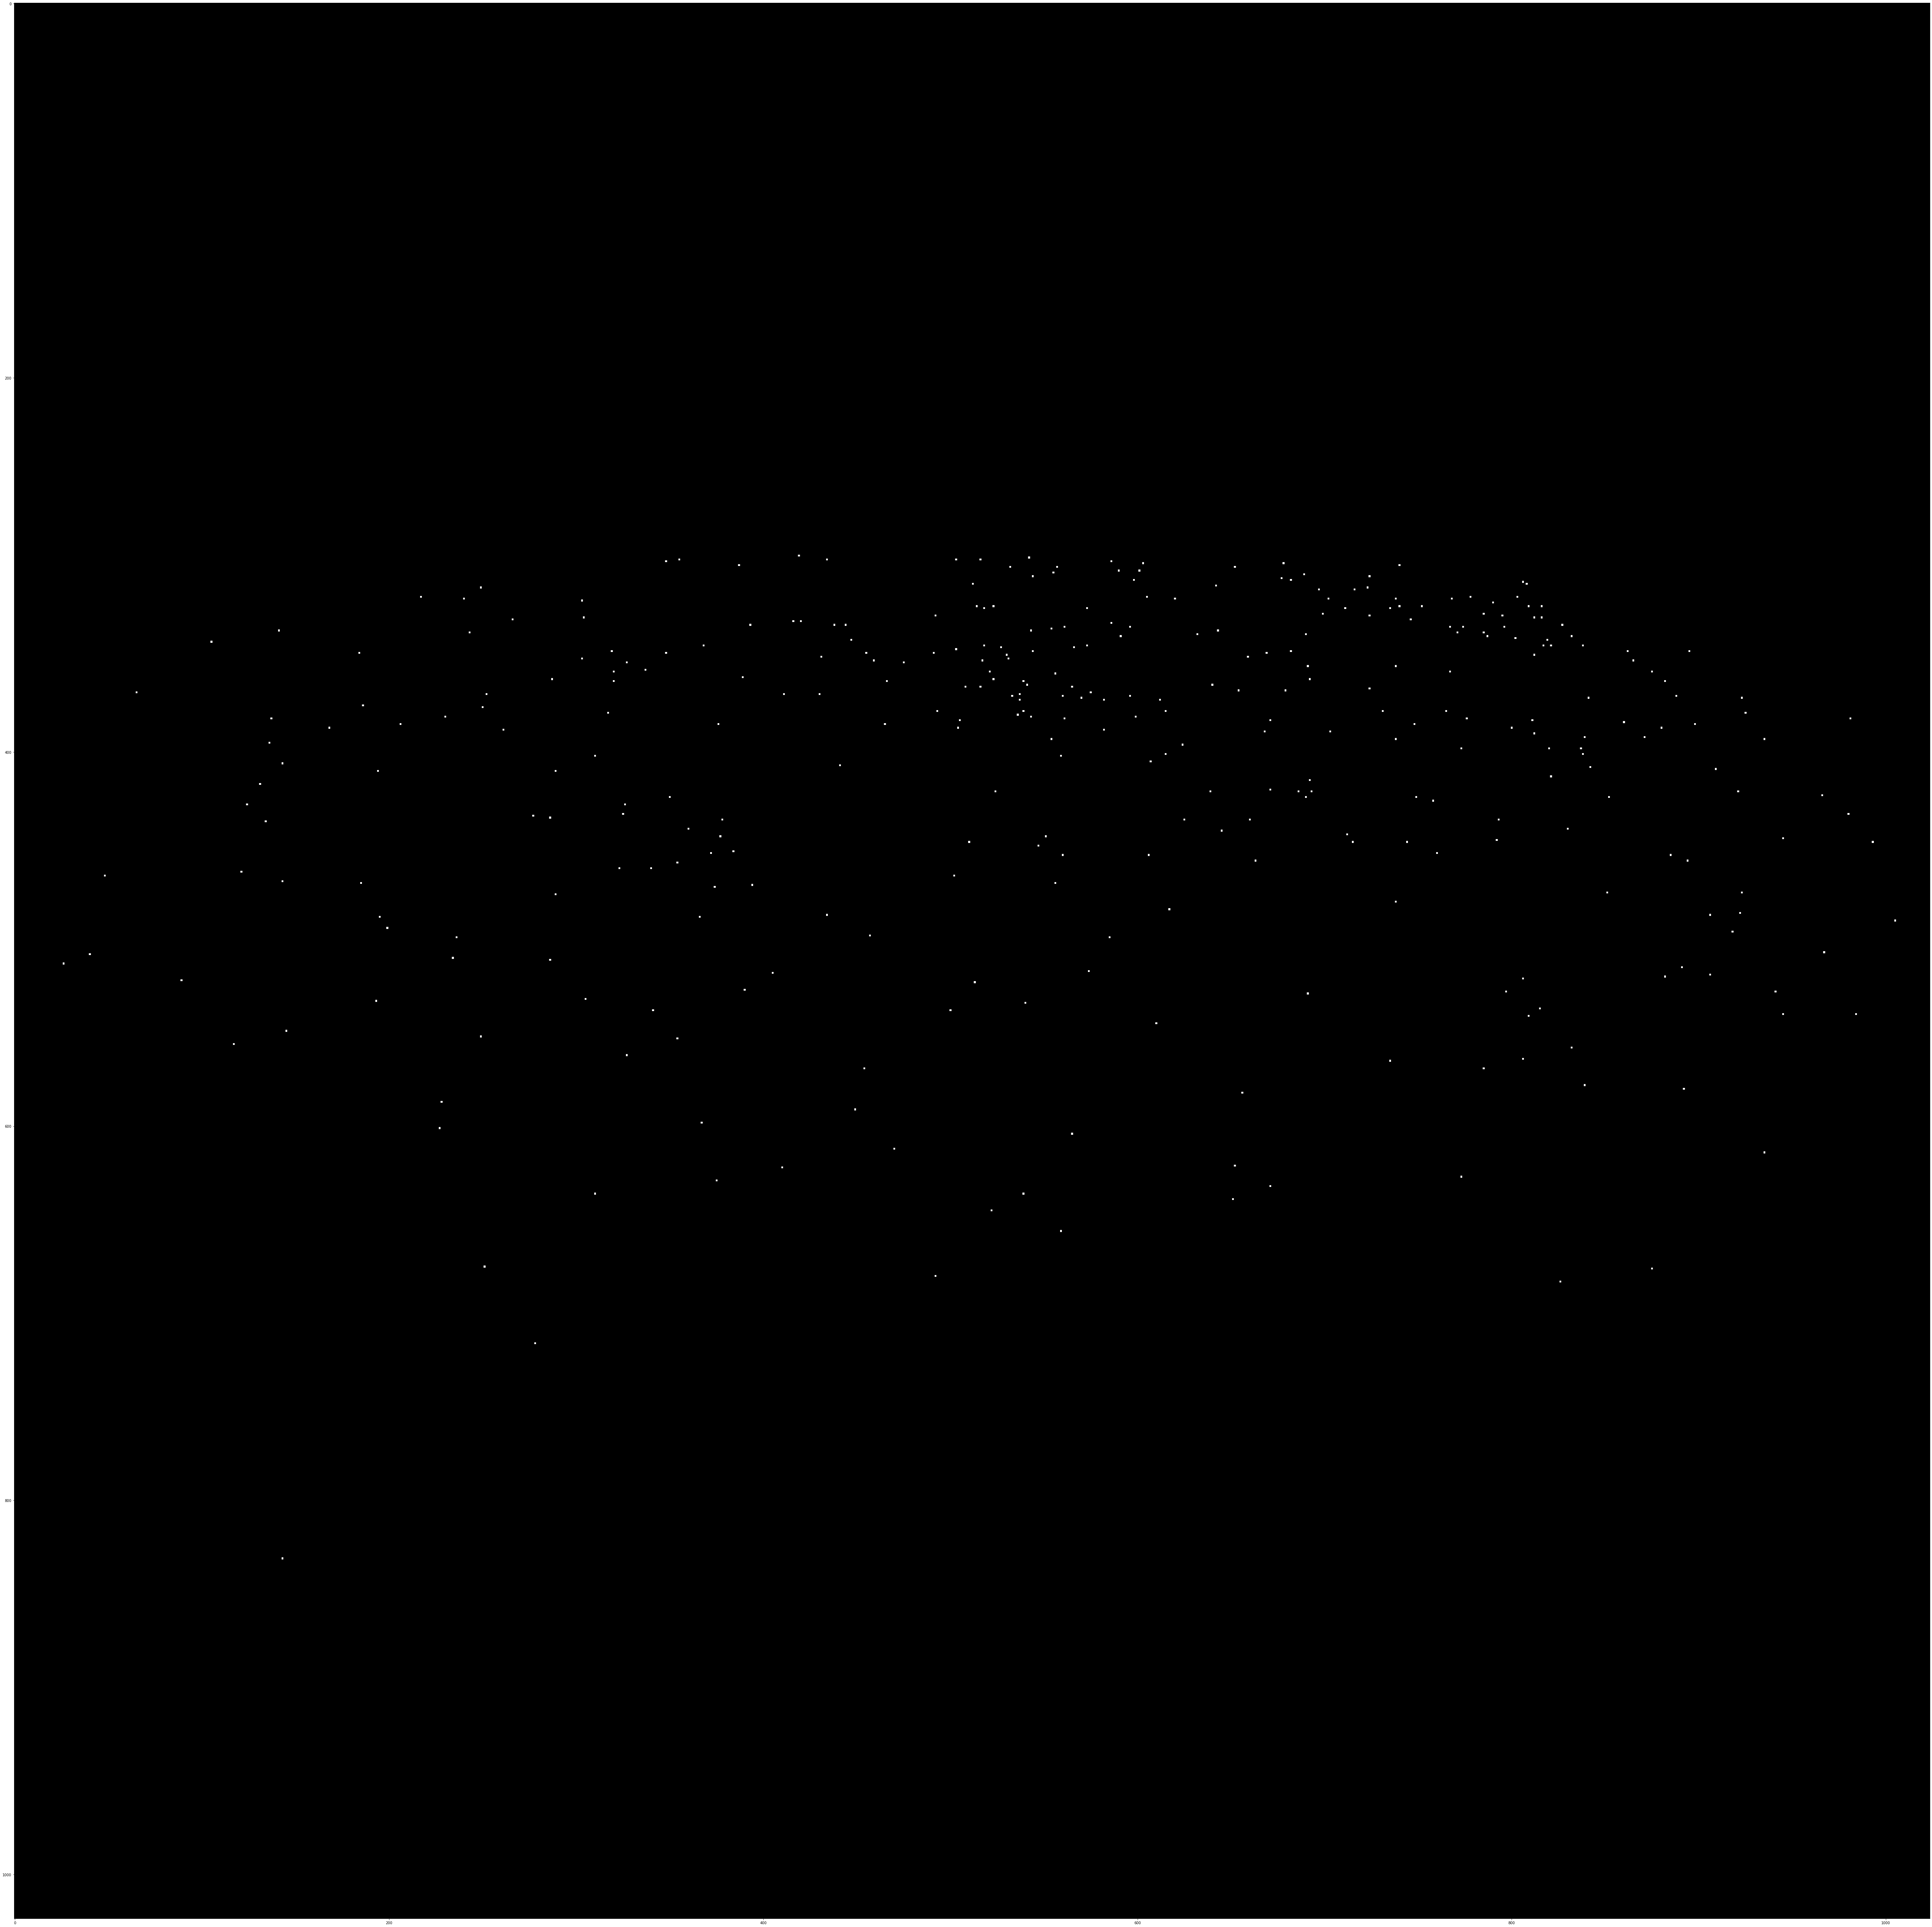

In [5]:
_, ax = plt.subplots(figsize=(100, 100))
ax.imshow(img, cmap='gray')

In [6]:
p_original = np.float32([[380, 391], [590, 391], [322, 457], [668, 457], ])
p_trans = np.float32([[388, 391], [598, 391], [388, 580], [598, 580]])

In [7]:
M = cv2.getPerspectiveTransform(p_original, p_trans)
img_trans = cv2.warpPerspective(img, M, (1000, 1000))

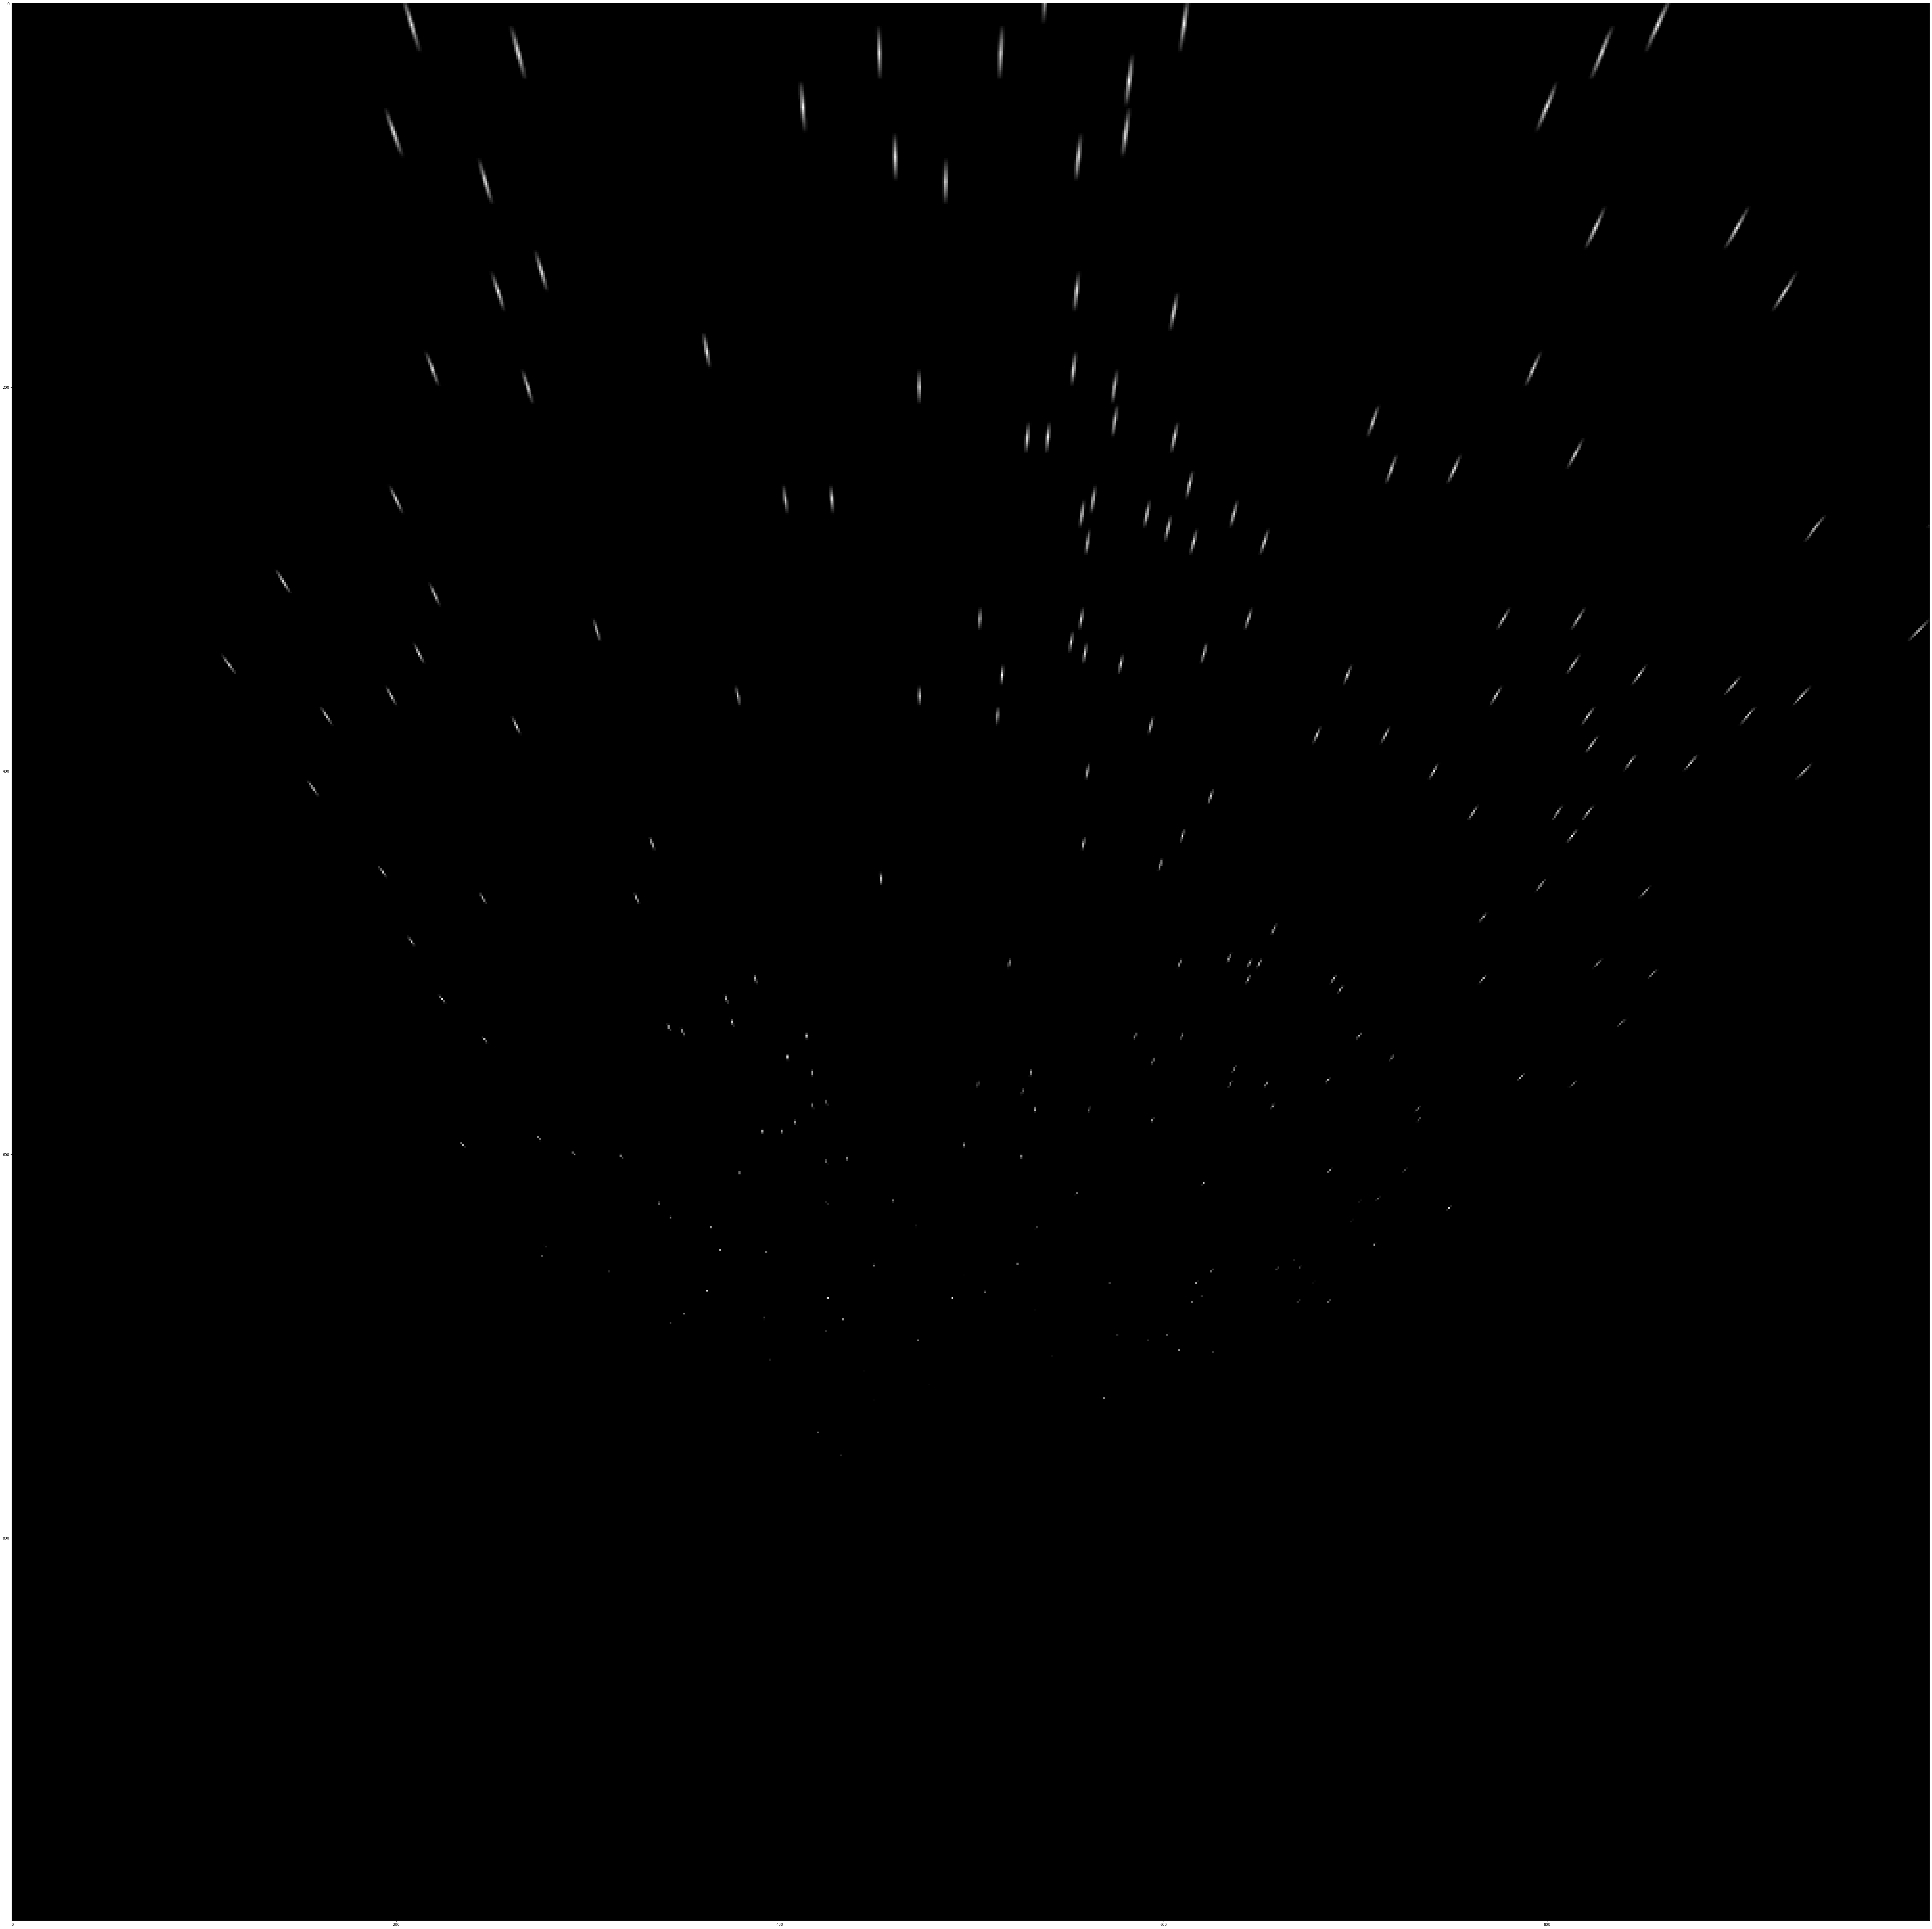

In [8]:
_, ax = plt.subplots(figsize=(100, 100))
ax.imshow(img_trans, cmap='gray')

In [9]:
_, img_trans_th_120 = cv2.threshold(img_trans, 160, 255, cv2.THRESH_BINARY)

In [10]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img_trans_th_120)

In [11]:
import random


random.seed(1234)

def put_color_to_objects(src_img, label_table):
    label_img = np.zeros_like(src_img)
    for label in range(1, label_table.max()+1):
        label_group_index = np.where(label_table == label)
        label_img[label_group_index] = random.sample(range(255), k=3)

    return label_img

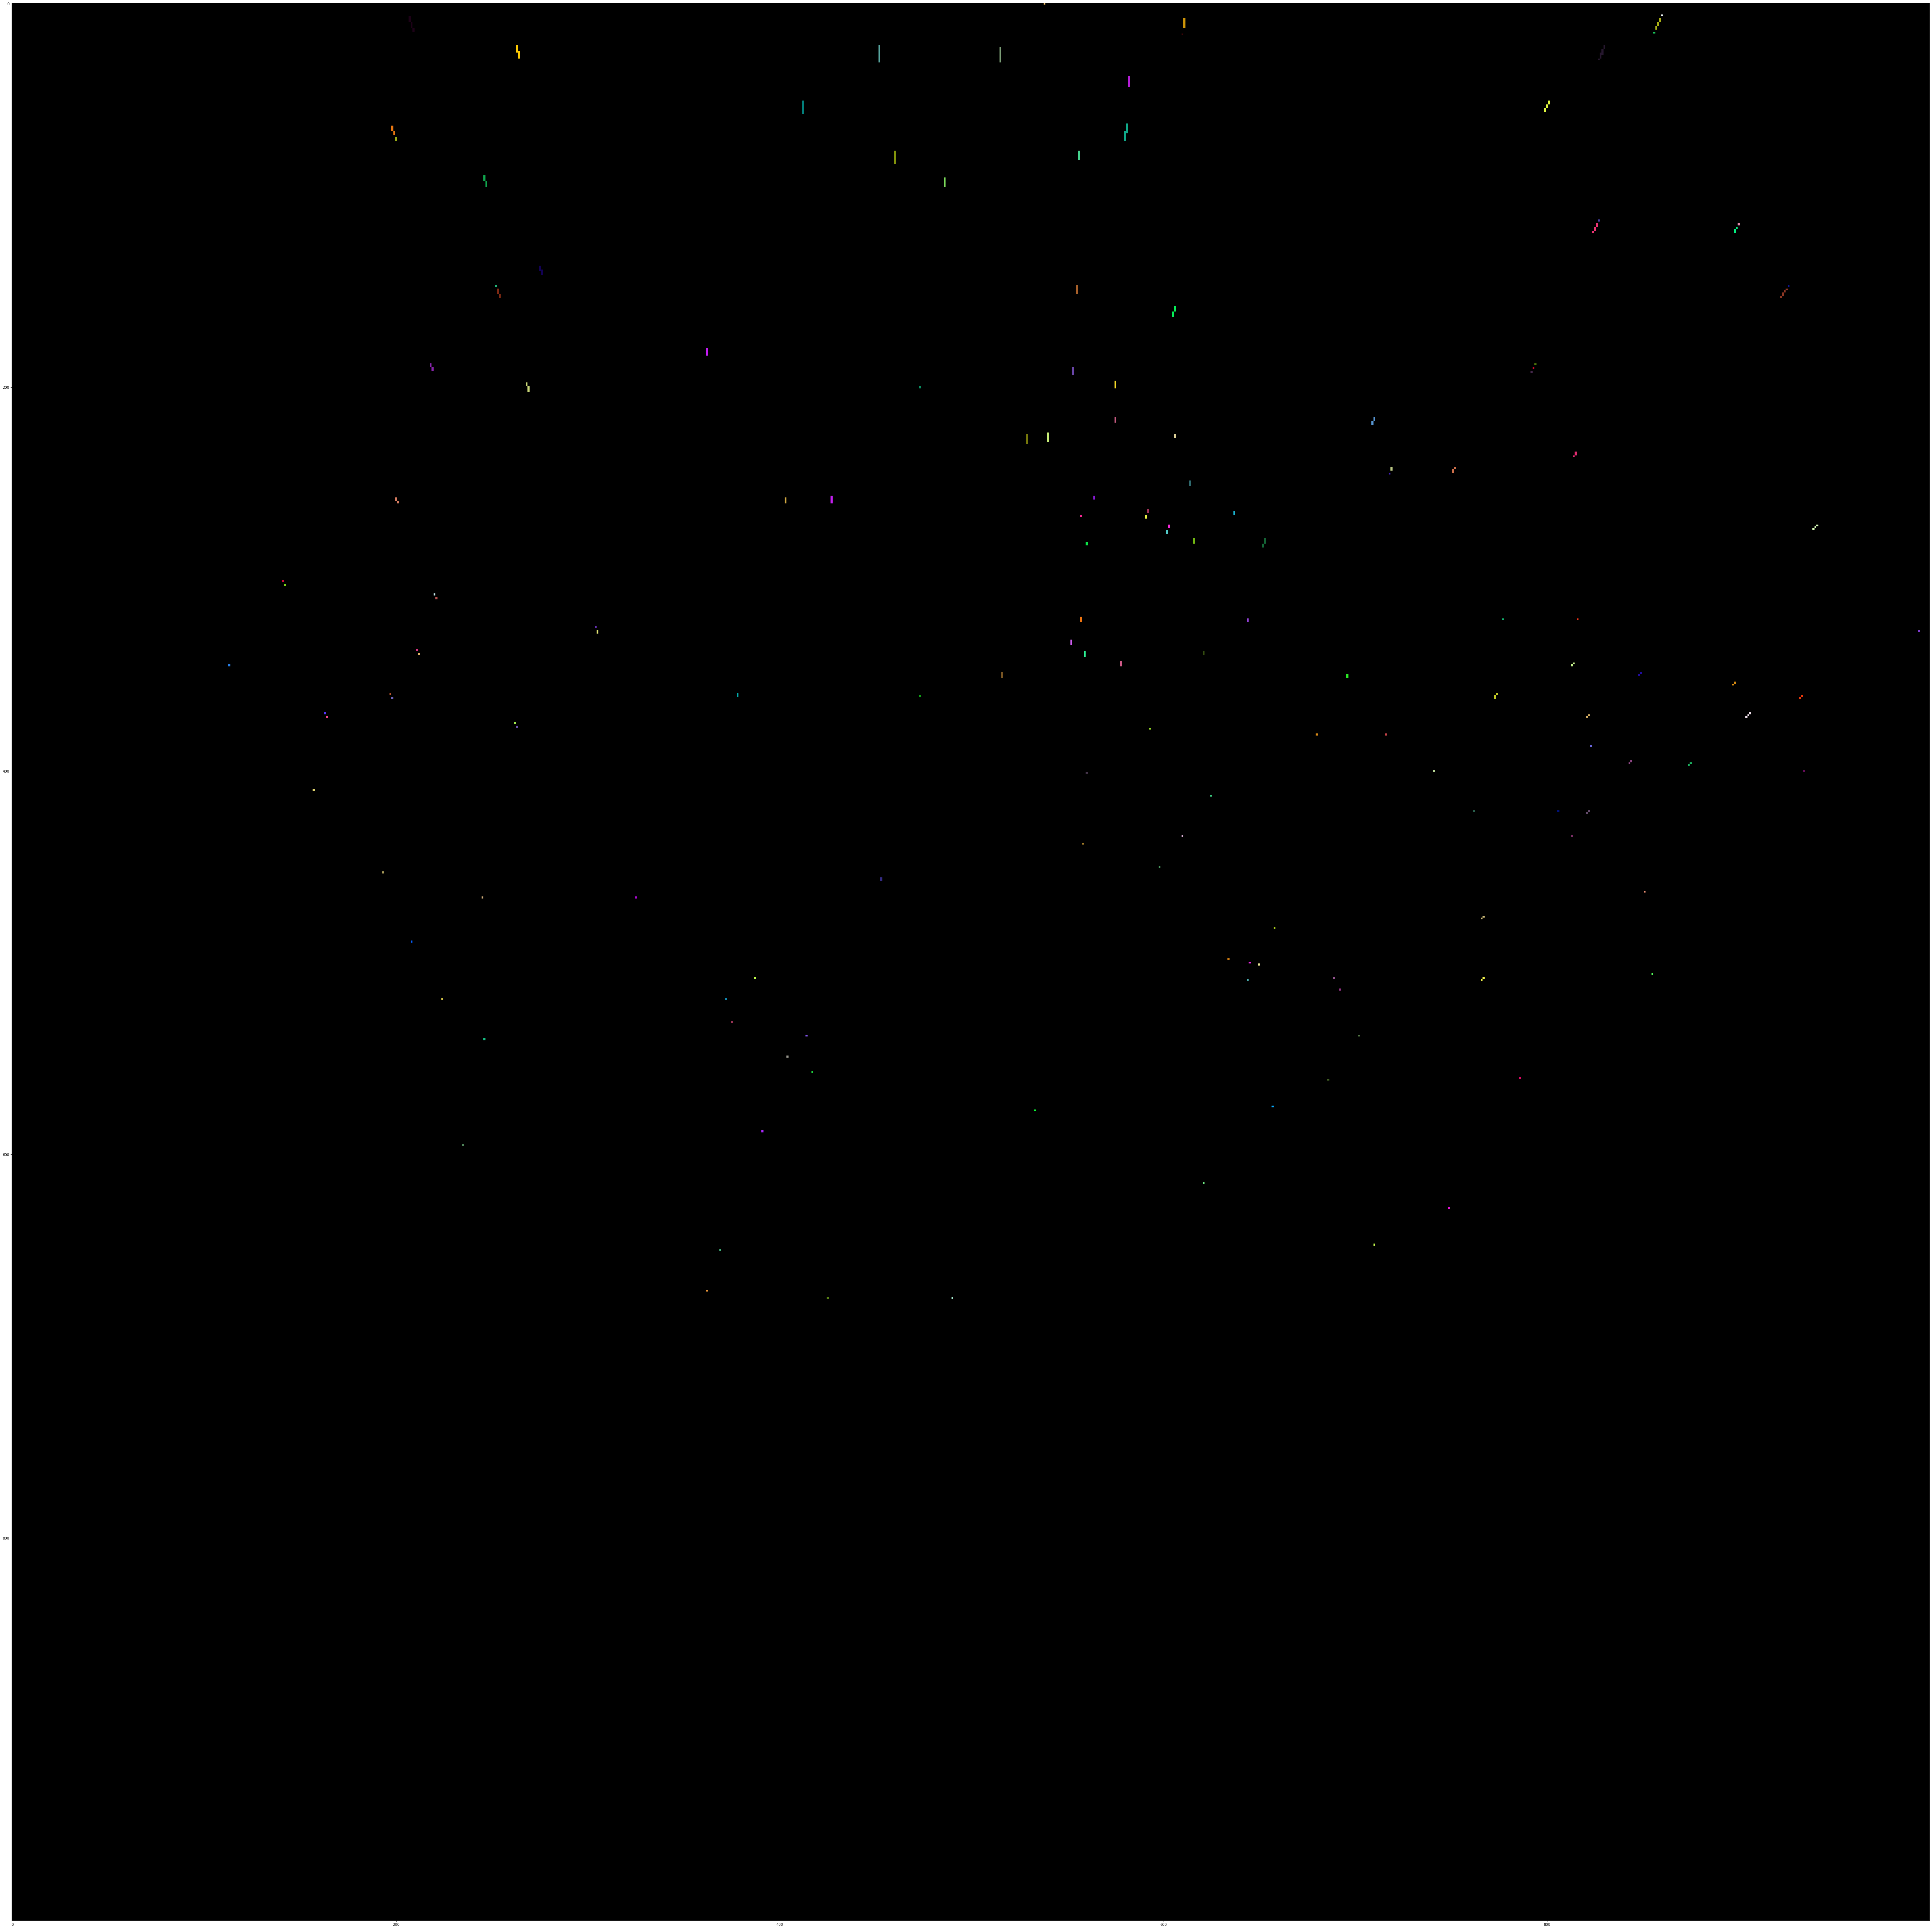

In [12]:
_, ax = plt.subplots(figsize=(100, 100))
ax.imshow(put_color_to_objects(cv2.cvtColor(img_trans_th_120, cv2.COLOR_GRAY2RGB), labels), cmap='gray')

In [13]:
def preprocessing(pp):
    img = np.zeros([1024, 1024], dtype=np.uint8)
    for i, j in pp:
        img[284+int(j), int(i)] = 255
    img = cv2.warpPerspective(img, M, (1000, 1000))
    _, img = cv2.threshold(img, 160, 255, cv2.THRESH_BINARY)
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img)

    return centroids

In [14]:
for i in range(100):
    res = preprocessing(pp=np.loadtxt(f"pp/pp_{i}.csv", delimiter=','))
    np.savetxt(f"pp3/pp_{i}.csv", res[1:], delimiter=',')

In [19]:
import sys
from collections import deque

import numpy as np
from tqdm import tqdm


class Vector2D(object):
    def __init__(self, idx):
        self.idx = idx
        self.x = 0.0
        self.y = 0.0


class Gap(object):
    def __init__(self, idx):
        self.idx = idx
        self.gap = 0.0
        self.angle = 0.0


class TP(object):
    def __init__(self, idx):
        self.idx = idx
        self.p0 = 0
        self.p1 = 0
        self.err = 0.0
        self.flag = False


def calc_gap(dx1, dx2):
    gx = Vector2D
    dst = Gap

    gx.x = dx2.x - dx1.x
    gx.y = dx2.y - dx1.y
    dst.gap = np.sqrt(gx.x ** 2 + gx.y ** 2)

    in_prod = dx1.x * dx2.x + dx1.y * dx2.y
    if np.sqrt(dx1.x ** 2 + dx1.y ** 2) * np.sqrt(dx2.x ** 2 + dx2.y ** 2) == 0:
        in_prod /= 1e-8
    else:
        in_prod /= np.sqrt(dx1.x ** 2 + dx1.y ** 2) * np.sqrt(dx2.x ** 2 + dx2.y ** 2)

    if np.abs(in_prod) > 1.0: in_prod /= np.abs(in_prod)

    dst.angle = np.arccos(in_prod)

    out_prod = dx1.x * dx2.y - dx1.y * dx2.x
    if out_prod < 0: dst.angle *= -1

    return dst, in_prod, out_prod


def ptv2t(img):
    pp0, pp1, pp2 = img[0], img[1], img[2]

    if pp0 is None or pp1 is None or pp2 is None:
        return None

    result = np.zeros([pp0.shape[0], 4])

    dx = [Vector2D(idx=x) for x in range(2)]
    dst = [Gap(idx=x) for x in range(1)]
    pp01 = [TP(idx=x) for x in range(pp0.shape[0])]
    s1, s2 = 10, 4.5  # 1st, 2nd search window
    eta = 15 * np.pi / 180  # criterion on angle
    npa = -1  # the number of available particle
    ntsp = 0  # the number for tracking the same particle

    # 2 times tracking
    for ii in range(pp0.shape[0]):  # Target (= 0th)
        flag = True  # init flag for the particle tracking
        cf, cfc = 1e10, 1e10  # arbitrary large number

        for jj in range(pp1.shape[0]):  # 1st
            dx[0].x = pp1[jj][0] - pp0[ii][0]
            dx[0].y = pp1[jj][1] - pp0[ii][1]

            if np.sqrt(dx[0].x ** 2 + dx[0].y ** 2) <= s1:
                for kk in range(pp2.shape[0]):  # 2nd
                    dx[1].x = pp2[kk][0] - pp1[jj][0]
                    dx[1].y = pp2[kk][1] - pp1[jj][1]

                    dst[0], ip0, op0 = calc_gap(dx[0], dx[1])
                    cfc = dst[0].gap ** 2

                    if dst[0].gap <= s2 and np.abs(dst[0].angle) <= eta and cfc < cf:
                        cf = cfc
                        if flag: npa += 1

                        pp01[npa].p0 = ii
                        pp01[npa].p1 = jj
                        pp01[npa].err = cf
                        pp01[npa].flag = True
                        flag = False

    # post-processing
    # If different particles track the same particle,
    # giving an error flag to particle which has larger error.
    for ii in range(npa):
        if pp01[ii].flag:
            for jj in range(ii + 1, npa):
                if pp01[ii].p1 == pp01[jj].p1:
                    if pp01[ii].err > pp01[jj].err:
                        pp01[ii].flag = False
                        ntsp += 1
                        break
                    else:
                        pp01[jj].flag = False
                        ntsp += 1

    # for debug
    # print(f"The number for tracking the same particle: {ntsp}")
    # print(f"The number of remaining particle by post processing: {npa - ntsp}\n")

    for ii in range(npa):
        if pp01[ii].flag:
            result[ii][0] = pp0[pp01[ii].p0][0]
            result[ii][1] = pp0[pp01[ii].p0][1]
            result[ii][2] = pp1[pp01[ii].p1][0] - pp0[pp01[ii].p0][0]
            result[ii][3] = pp1[pp01[ii].p1][1] - pp0[pp01[ii].p0][1]

    return result[:npa]

In [20]:
data_list = deque([None, None, None])

for n in tqdm(range(0, 30, 10)):
    data_list.popleft()
    tmp = np.loadtxt(f"pp3/pp_{n}.csv", delimiter=',', skiprows=1)
    data_list.append(tmp)

    r = ptv2t(img=data_list)

100%|██████████| 3/3 [00:00<00:00,  8.36it/s]


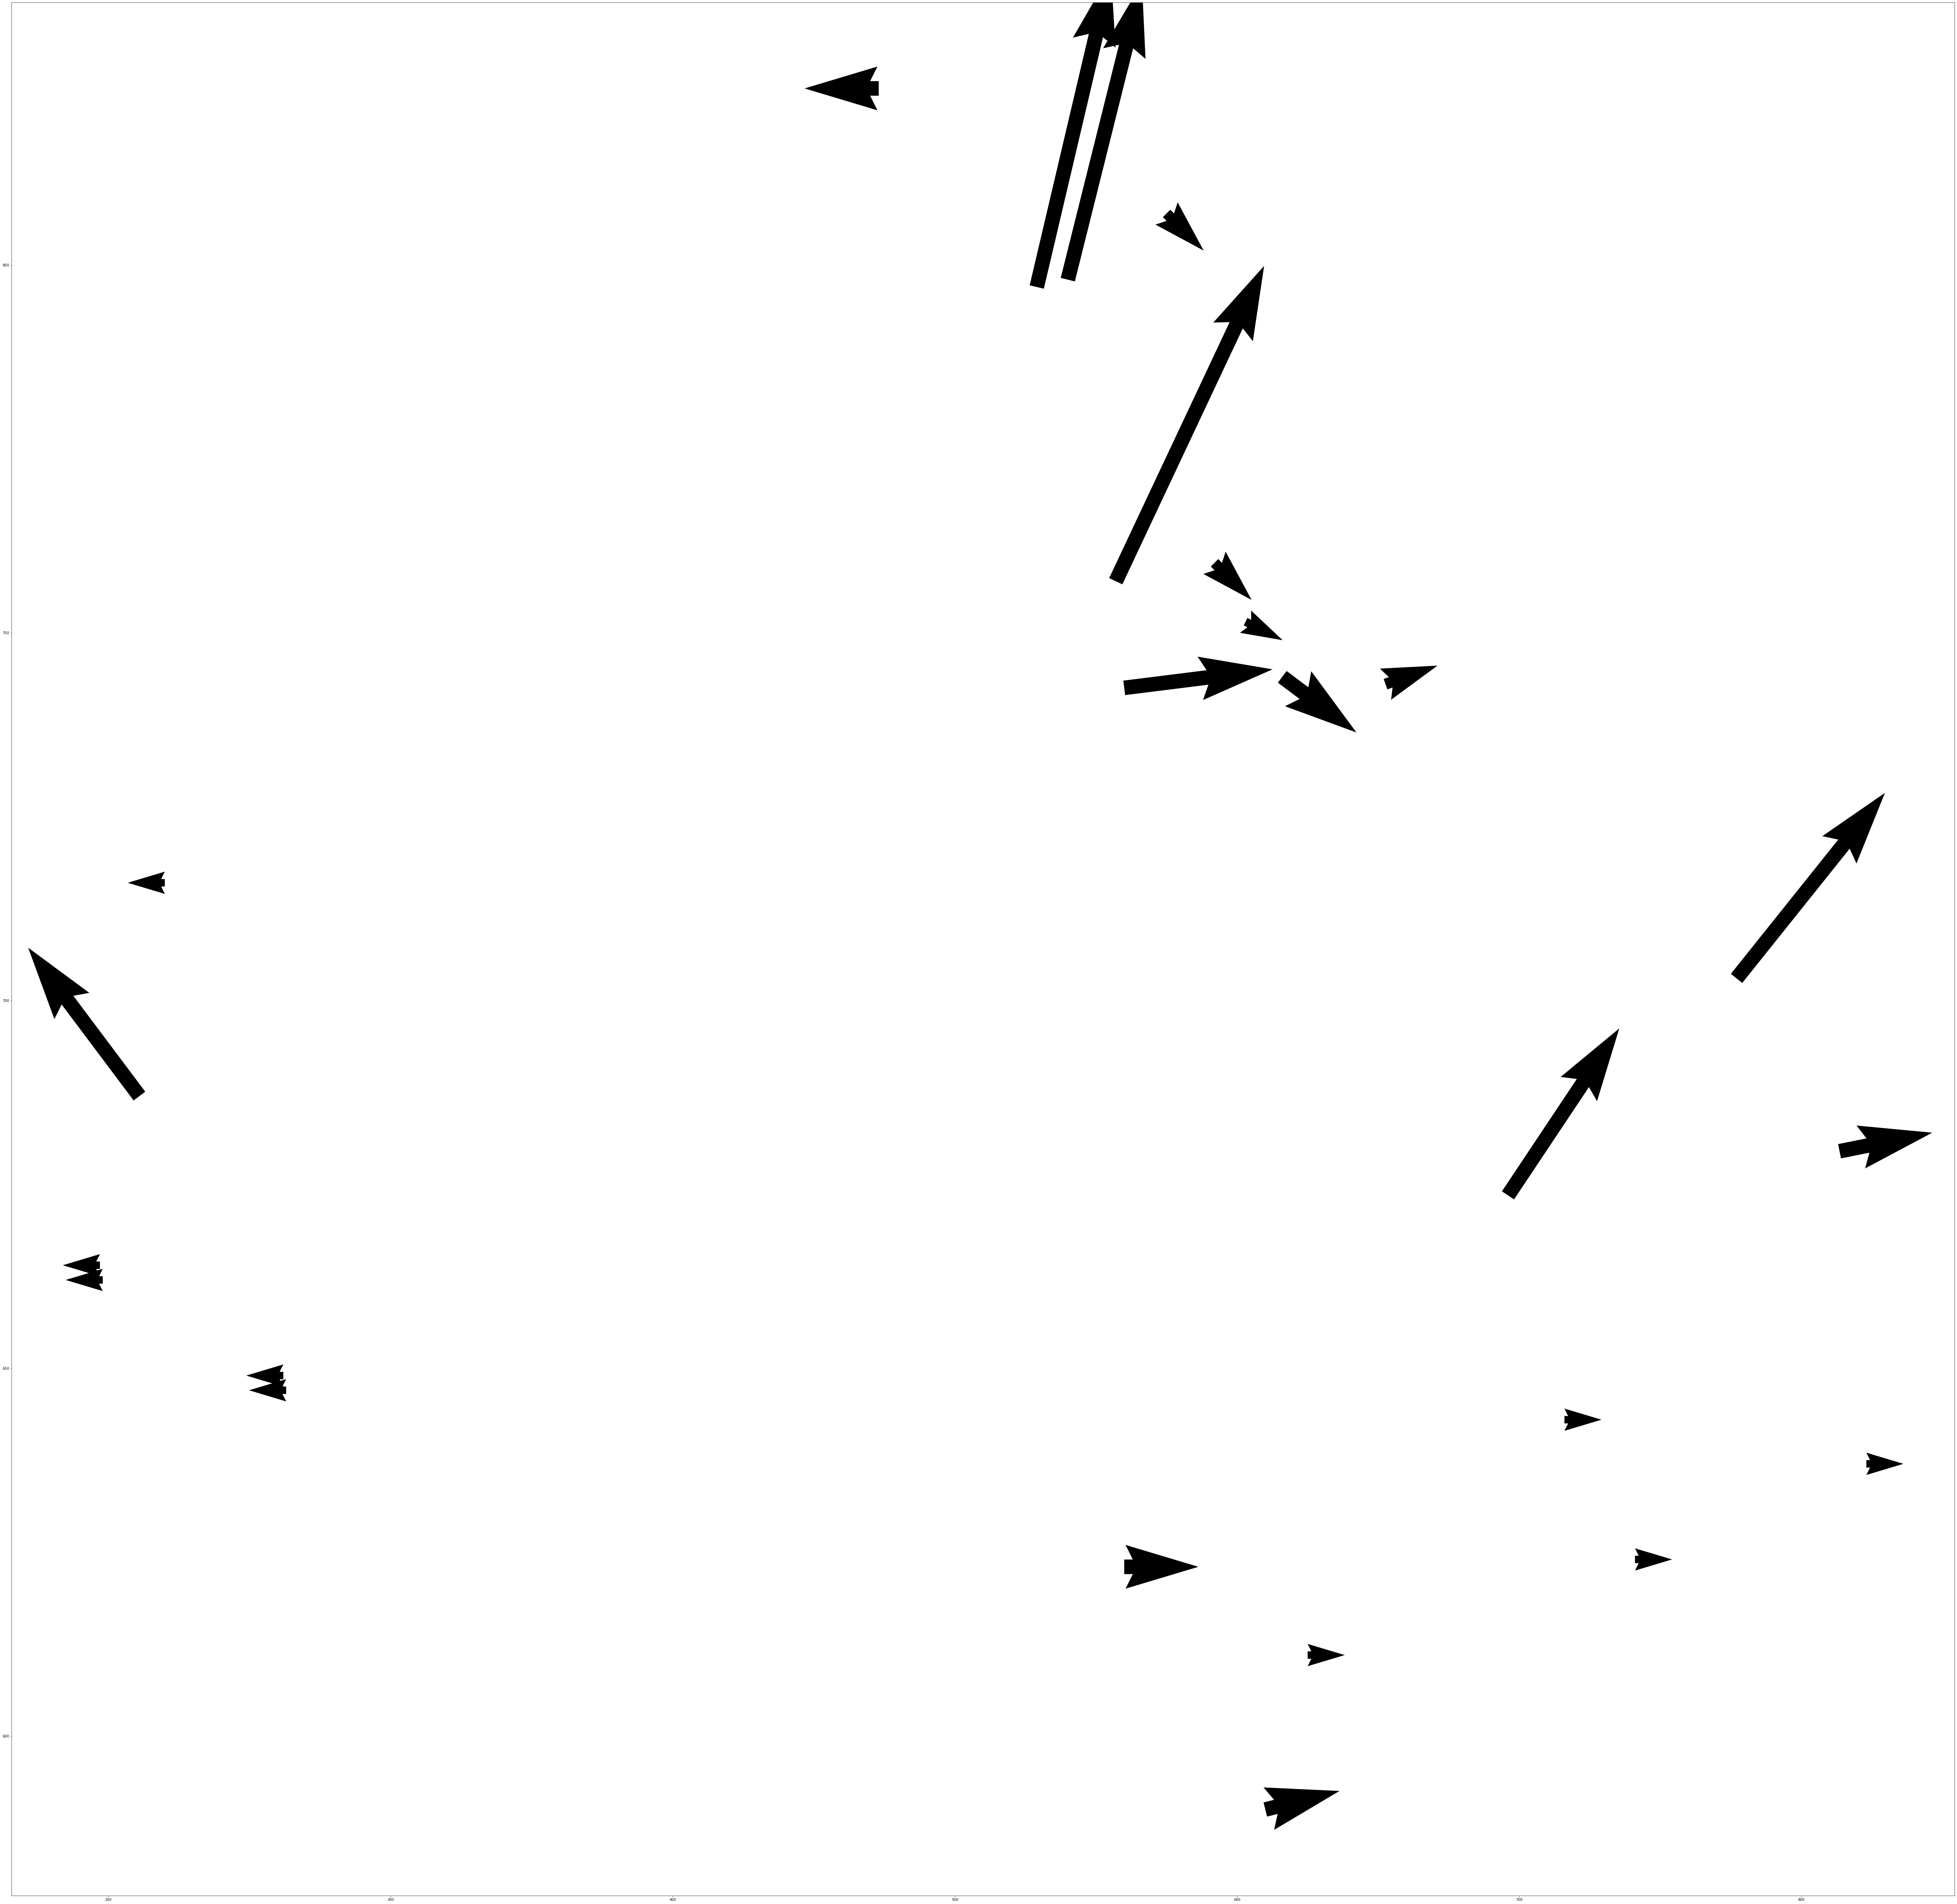

In [21]:
fig, ax = plt.subplots(figsize=(100, 100))
ax.quiver(r[:, 0], 1024-r[:, 1], r[:, 2], -r[:, 3])
plt.show()